<a href="https://colab.research.google.com/github/Sahel-Eskandar/Text-Classification-Sentimental-Analysis/blob/main/16_Text_Classification_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook includes the following techniques for text classification and sentimental analysis:

**1. Text preprocessing**

      - tokenization: breaking text into words or phrases

      - stopword removal: removing common words that don't carry much meaning

      - stemming: reducing words to their base form)
**2. Feature extraction**

      - bag-of-words: counting the frequency of each word in a document 

      - TF-IDF: weighing words by their importance in a document 

      - word embeddings: representing words as vectors in a high-dimensional space

**3. Machine learning algorithms**

    - Naive Bayes

    - XGBoost 

    - LSTMs

    - Transformers (such as BERT)

**4. Evaluation metrics**

**5. Model optimization**

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
encoding_errors='ignore'

In [ ]:
!pip install wordcloud

In [ ]:
!pip install nltk

In [ ]:
!pip install spacy

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [2]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score

In [3]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.6 MB/s eta 0:00:00


In [8]:
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Embedding
from keras.layers import LSTM, Embedding,BatchNormalization, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [9]:
# Defining the global variables for the color schemes we will incorporate
pblue = "#496595"
pb2 = "#85a1c1"
pb3 = "#3f4d63"
pg = "#c6ccd8"
pb = "#202022"
pbg = "#f4f0ea"

pgreen = px.colors.qualitative.Plotly[2]

In [10]:
url = 'https://raw.githubusercontent.com/Sahel-Eskandar/Text-Classification-Sentimental-Analysis/main/Data/spam.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1", error_bad_lines=False)

In [11]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [12]:
df.dtypes

v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

In [13]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [14]:
df.dropna(axis=1, inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
df.rename(columns={"v1":"label", "v2":"text"}, inplace=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# Finding maximum length of text message

np.max(df['text'].apply(lambda x: len(x.split())).values)

171

#<h2>Data preprocessing</h2>

##<h2>Exploratory data analysis</h2>

In [17]:
# Checking balance of dataset
grouped_df = df.groupby('label').count().values.flatten()
grouped_df

array([4825,  747])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [19]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The 'text' property is a string and must be specified as:

      - A string
      - A number that will be converted to a string
      - A tuple, list, or one-dimensional numpy array 
      
The 'x' and 'y' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [20]:
fig = go.Figure()

fig.add_trace(go.Bar(
        x=['ham'],
        y=[grouped_df[0]],
        name='Safe',
        text=[grouped_df[0]],
        textposition='auto',
        marker_color=pblue
)
             )
fig.add_trace(go.Bar(
        x=['spam'],
        y=[grouped_df[1]],
        name='Spam',
        text=[grouped_df[1]],
        textposition='auto',
        marker_color=pg
))

fig.update_layout(
    title='Class distribution in the dataset')

fig.show()

In [21]:
# Creating series with length as index
# Sorting the series by index i.e. length
len_df_ham = df[df['label']=='ham'].text.apply(lambda x: len(x.split())).value_counts().sort_index()
len_df_spam = df[df['label']=='spam'].text.apply(lambda x: len(x.split())).value_counts().sort_index()

In [22]:
len_df_ham

1       41
2       39
3       78
4      197
5      353
      ... 
103      1
109      1
125      2
162      1
171      1
Name: text, Length: 82, dtype: int64

In [23]:
len_df_spam

2      2
3      1
4      1
5      3
6      4
7      4
8      8
9      2
10     5
11     4
12    12
13    14
14     6
15    12
16     8
17    12
18    15
19    21
20    25
21    16
22    49
23    47
24    62
25    67
26    65
27    79
28    78
29    42
30    36
31    14
32    21
33     7
34     3
35     2
Name: text, dtype: int64

In [24]:
# X-axis consists of the length of the msgs
# Y-axis consists of the frequency of those lengths

fig = go.Figure()
fig.add_trace(go.Scatter(
x=len_df_ham.index,
y=len_df_ham.values,
name='Safe',
fill='tozeroy',
marker_color=pblue))

fig.add_trace(go.Scatter(
x=len_df_spam.index,
y=len_df_spam.values,
name='Spam',
fill='tozeroy',
marker_color=pg
))

fig.update_layout(
    title='Frequency of SMS lengths')
fig.update_xaxes(range=[0, 80])
fig.show()

We can see that the safe SMS messages are much shorter than the spam messages.

In [25]:
def cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [26]:
df['text']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

In [27]:
df['text'] = df['text'].apply(cleaning)
df['text']

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in  a wkly comp to win fa cup final...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the  time we have tried  contact u u h...
5568                  will ì b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: text, Length: 5572, dtype: object

##Stopword removal

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
# Removing stop words
stop_words = stopwords.words('english')
more = ['u', 'im', 'c']
stop_words = stop_words + more


def sw_rem(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['text'] = df['text'].apply(sw_rem)
df['text']

0       go jurong point crazy available bugis n great ...
1                                   ok lar joking wif oni
2       free entry  wkly comp win fa cup final tkts  m...
3                           dun say early hor already say
4             nah dont think goes usf lives around though
                              ...                        
5567     time tried  contact å£ pound prize  claim eas...
5568                          ì b going esplanade fr home
5569                         pity  mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: text, Length: 5572, dtype: object

##<h2>Stemming and lemmatization</h2>

Documents and other forms of text use different forms of the same words, such as play, playing, played. There are families of derivationally related words that have similar meanings. Our main task with stemming and lemmatization is to reduce all these derived words into the parent/family word, therefore reducing the total vocabulary while retaining information.

* **Stemming** - Omits the ends of words to achieve the goal correctly, this works **most of the times** and can also remove the derivational suffix

* **Lemmatization** - Working with a vocabulary and morphological analysis of wrods, removing inflectional endings only and returning the base and dictionary form of a word.

As we do not require much emphasis on words, we will focus more on stemming than lemmatization,.

<h3>Stemming algorithms</h3>

We have multiple algorithms to achieve our stemming goals, some of them are as follows:

* PorterStemmer - Fast and efficient. Strips off the end (suffix) to produce the stems. It does not follow linguistics but rather a set of 05 rules for diferent cases. 

* SnowballStemmer - Generate a set of rules for any language. These are useful for non-english stemming tasks.

* LancasterStemmer - Iterative algorithm, uses about 120 rules, it tries to find an applicable rule by the last character of each word. The last character may be omitted or replaced.

In [30]:
stems = nltk.SnowballStemmer('english')

def stemming(text):
    text = ' '.join(stems.stem(word) for word in text.split())
    return text

In [31]:
df['text'] = df['text'].apply(stemming)
df.head()

,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif oni
2,spam,free entri wkli comp win fa cup final tkts may...
3,ham,dun say earli hor alreadi say
4,ham,nah dont think goe usf live around though


In [32]:
# Creating a pipeline

def pipeline(text):
    text = cleaning(text)
    text = ' ' .join(word for word in text.split(' ') if word not in stop_words)
    text = ' '.join(stems.stem(word) for word in text.split(' '))
    return text

In [33]:
df['text'] = df['text'].apply(pipeline)
df.head()

,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif oni
2,spam,free entri wkli comp win fa cup final tkts may...
3,ham,dun say ear hor alreadi say
4,ham,nah dont think goe usf live around though


In [34]:
# Encoding the categorical target variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['label'])

df['label_num'] = le.transform(df['label'])
df.head()

,label,text,label_num
0,ham,go jurong point crazi avail bugi n great world...,0
1,ham,ok lar joke wif oni,0
2,spam,free entri wkli comp win fa cup final tkts may...,1
3,ham,dun say ear hor alreadi say,0
4,ham,nah dont think goe usf live around though,0


##<h2>Visualizing tokens</h2>

In [35]:
# This will combine all the text values for safe sms
#' '.join(text for text in df[df['label']=='ham'].text)

In [36]:
from PIL import Image
import requests
from io import BytesIO

url1 = 'https://raw.githubusercontent.com/Sahel-Eskandar/Text-Classification-Sentimental-Analysis/main/Data/upvote.png'

response1 = requests.get(url1)
img = Image.open(BytesIO(response1.content))

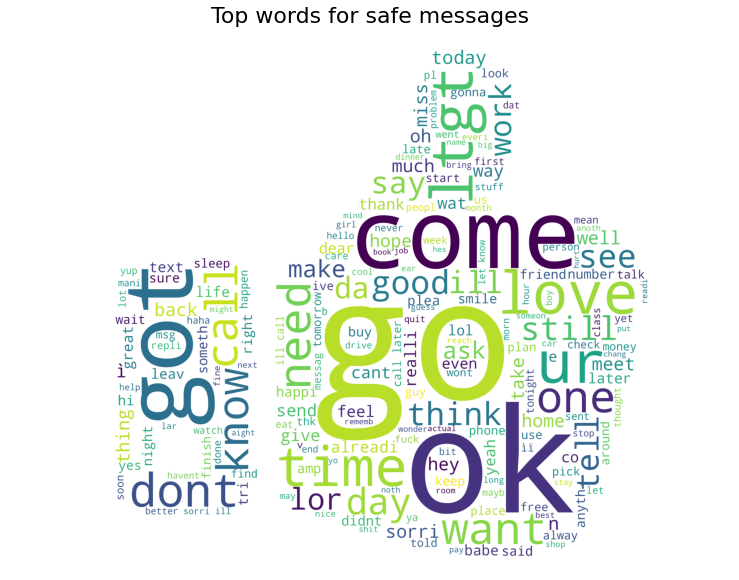

In [37]:
# Extracting the twitter word cloud mask
upvote_mask = np.array(img)
wc = WordCloud(background_color='white', max_words=200, mask=upvote_mask)

wc.generate(' '.join(text for text in df[df['label']=='ham'].text))
plt.figure(figsize=(15, 10))
plt.title('Top words for safe messages', fontdict={'size':22})
plt.imshow(wc)
plt.axis('off')
plt.show()

In [38]:
url2 = 'https://raw.githubusercontent.com/Sahel-Eskandar/Text-Classification-Sentimental-Analysis/main/Data/dislike.png'

response2 = requests.get(url2)
img2 = Image.open(BytesIO(response2.content))

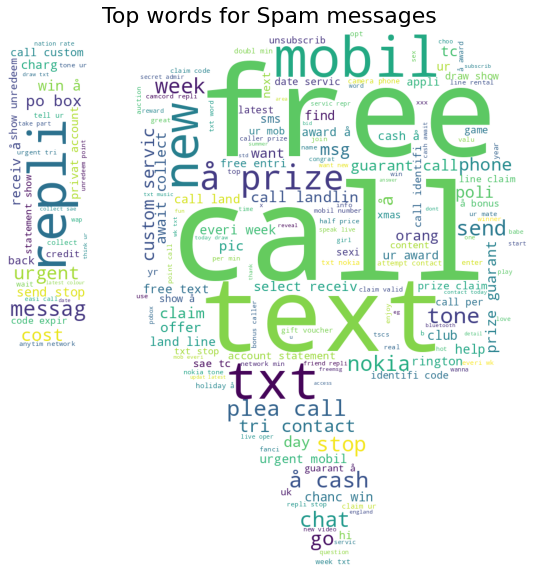

In [39]:
# Extracting the twitter word cloud mask
dislike_mask = np.array(img2)
wc = WordCloud(background_color='white', max_words=200, mask=dislike_mask)

wc.generate(' '.join(text for text in df[df['label']=='spam'].text))
plt.figure(figsize=(15, 10))
plt.title('Top words for Spam messages', fontdict={'size':22})
plt.imshow(wc)
plt.axis('off')
plt.show()

#Feature extraction

##<h2>Vectorization</h2>

We currently have each text record in string format. We need to convert each of those records into a vector that our models can work with. We will first do this using the bag-of-words model.

We will use two major approaches here

* **CountVectorizer** - Working on frequency of each word in the given string.

* **Term frequency-inverse document frqeuency TFIDF** - Works on frequency divided by the appearance of the given word in the total documents.

In [40]:
x = df['text']
y = df['label_num']

len(x), len(y)

(5572, 5572)

In [41]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [42]:
# First working with count vectorizer

from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
count = CountVectorizer()
count.fit(x)

x_train_num = count.transform(x_train)
x_test_num = count.transform(x_test)

The CountVectorizer model can be tuned in a variety of ways:

* Stop words - Extremely common words can be omitted by the model by setting this parameter to the language corresponding to the text.

* ngram_range - It pairs up words together as features. If we consider bigrams and we have a sentence "I am happy", we will have two features - ["I am", "am happy"]. We can define a range of ngrams, so if we have the same sentence with a range from 1 to 2, our features will be:  `["I", "am", "happy", "I am", "am happy"]`. This increase is features helps to fine tune the model.

* min_df, max_df - Minimum and maximum frequencies of words of n-grams that can be used as features. If either of the conditions are not met, the feature will be omitted.

* max_features - Choose the most frequent words and drop everything else.

In [43]:
# Example of a tuned model
count_tuned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [44]:
# Working with TF-IDF now
from sklearn.feature_extraction.text import TfidfTransformer
# We are using transformer here
# If we use vectorizer, we can directly use the text
tfidf = TfidfTransformer()

tfidf.fit(x_train_num)
x_train_tfidf = tfidf.transform(x_train_num)

x_train_tfidf

<4179x6696 sparse matrix of type '<class 'numpy.float64'>'
	with 32361 stored elements in Compressed Sparse Row format>

##<h2>Working with Embeddings - GloVe</h2>

In [45]:
text = df['text']
label = df['label_num']

In [46]:
# Calculating the total vocabulary
tk = Tokenizer()
tk.fit_on_texts(text)

vocab = len(tk.word_index)+1
vocab

6724

Now we will proceed with converting the text to numerical values and also padding the vectors so each of them are of equal length. 

In [47]:
# Maximum length
max_len = np.max(df['text'].apply(lambda x: len(x.split())).values)
max_len

80

In [48]:
text

0       go jurong point crazi avail bugi n great world...
1                                     ok lar joke wif oni
2       free entri wkli comp win fa cup final tkts may...
3                             dun say ear hor alreadi say
4               nah dont think goe usf live around though
                              ...                        
5567    time tri contact å£ pound prize claim easi cal...
5568                              ì b go esplanad fr home
5569                              piti mood soani suggest
5570    guy bitch act like id interest buy someth el n...
5571                                       rofl true name
Name: text, Length: 5572, dtype: object

In [49]:
def embedding(text):
    return tk.texts_to_sequences(text)

train_padded = pad_sequences(embedding(text), 80, padding='post')
train_padded

array([[   2, 3180,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6722, 1002, 6723, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1987,  378,  170, ...,    0,    0,    0]], dtype=int32)

##<h2>GloVe Embeddings</h2>

These embeddings are based on the principle that we can derive sematic relationships between words from their co-occurence matrix. This embedding focuses on words co-occurrences over the whole corpus. 

They are a form of word representation that try to merge human understanding of languages into their structure. They have a learned representation in an n-dimension space, where words with similar meanings have similar embeddings. Two similar words are represented by almost similar vectors that are at a small distance in the vector space.

When using a vector space, all the words are represented as vectors in a predefined N-dimension vector space. Each word is mapped to a vector and the vector values are learned in a way that resembles a neural network.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
# Using our helper functions for GloVe

embedding_dict = dict()
embedding_dim = 100

# Each word is represented in one line in the text file
# Format - Word val1 val2 val3......val-n for n-dimension vector space

with open('../content/drive/MyDrive/Data/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector = np.asarray(records[1:], dtype='float32')
        embedding_dict[word] = vector

In [52]:
# Creating a matrix for each word as index (word numerical value extracted from tokenizer
# with N-features (corresponding to GloVe)
# We will replace the matrix elements by the words and their embeddings

# Our embeddings will also consist embeddings for padding
embedding_matrix = np.zeros((vocab, embedding_dim))

for word, index in tk.word_index.items():
    embed_vector = embedding_dict.get(word)
    if embed_vector is not None:
        embedding_matrix[index] = embed_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
# We will be creating seaborn and plotly confusion matrices
import plotly.figure_factory as ff
x_axes = ['Safe','Spam']
y_axes = ['Spam', 'Safe']

def conf_matrix(z, x=x_axes, y=y_axes):
    z = np.flip(z, 0)
    # Change each element of z to string 
    # This allows them to be used as annotations
    z_str = [[str(y) for y in x] for x in z]
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_str)
    
    fig.update_layout(title_text='Confusion matrix', xaxis=dict(title='Predicted Value'),
                     yaxis=dict(title='Real value'))
    
    fig['data'][0]['showscale'] = True
    return fig

In [54]:
from sklearn.metrics import confusion_matrix
categories=['Safe', 'Spam']
def seaborn_conf(y, ypred):
    y_true = ["Safe", "Spam"]
    y_pred = ["Safe", "Spam"]
    cf = confusion_matrix(y, ypred)
    df_cm = pd.DataFrame(cf, columns=np.unique(y_true), index = np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted value')
    plt.ylabel('Real value')
    plt.show()

#<h2>Model creation and prediction</h2>

## Naive Bayes

We will first start with the **naive bayes classifier** which comes from a family of simple "probabilistic classifiers" based on application of Bayes theroem with strong independent assumptions between features.

The model is highly scalable, with number of parameters being linear with number of variables. 

In [55]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model - CountVectorizer model
nb.fit(x_train_num, y_train)

MultinomialNB()

In [56]:
# Class and probability predictions
yp_class = nb.predict(x_test_num)
yp_prob = nb.predict_proba(x_test_num)[:, 1]

0.9720028715003589


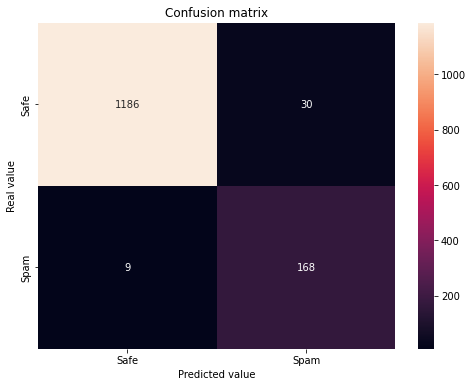

In [57]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, yp_class))
seaborn_conf(y_test, yp_class)

In [58]:
metrics.roc_auc_score(y_test, yp_prob)

0.9939530367231638

##<h2>Naive Bayes + TF-IDF</h2>

In [59]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

0.9712849964106246


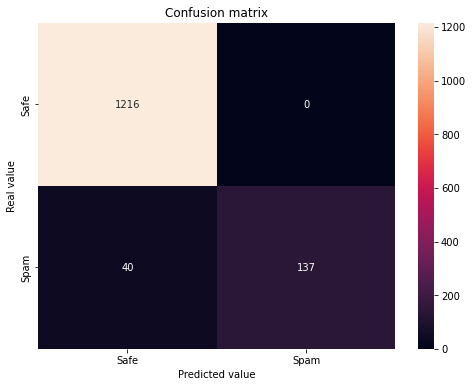

In [60]:
pipe.fit(x_train, y_train)
yp_class = pipe.predict(x_test)
print(metrics.accuracy_score(y_test, yp_class))
seaborn_conf(y_test, yp_class)

##<h2>XGBoost</h2>

In [ ]:
!pip install xgboost

In [61]:
import xgboost as xgb
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=6,
        n_estimators=90,
        use_label_encoder=False,
        eval_metric='auc'
    ))
    ]
)

Training accuracy score: 0.9789423307011247
Testing accuracy score: 0.9720028715003589


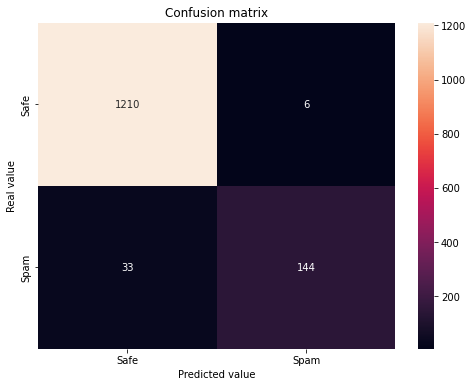

In [62]:
pipe.fit(x_train, y_train)
yp_class_test = pipe.predict(x_test)
yp_class_train = pipe.predict(x_train)

print('Training accuracy score: {}'.format(metrics.accuracy_score(y_train, yp_class_train)))
print('Testing accuracy score: {}'.format(metrics.accuracy_score(y_test, yp_class_test)))

seaborn_conf(y_test, yp_class_test)

##<h2>LSTMs and GloVE embeddings</h2>

In [63]:
train_padded.shape

(5572, 80)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(train_padded, label, test_size=0.2)

In [65]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                   output_dim=embedding_matrix.shape[1],
                   weights=[embedding_matrix],
                   input_length=max_len
                   )
         )
model.add(Bidirectional(LSTM(max_len, return_sequences=True, recurrent_dropout=0.15)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(max_len, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(max_len, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 100)           672400    
                                                                 
 bidirectional (Bidirectiona  (None, 80, 160)          115840    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 160)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                        

In [66]:
# Defining Callbacks
# Checkpoints in case our model stops training due to some circumstance - saving progress
checkpoints = ModelCheckpoint('ck_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
# Reducing the learning rate if no improvement in validation loss over 5 epochs
# This is to train the model better
reduce_lr = ReduceLROnPlateau(monitor='val_loss', vactor=0.1, verbose=1, patience=5, min_lr=0.0001)

In [67]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1, callbacks=[reduce_lr, checkpoints])

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9141
Epoch 1: val_loss improved from inf to 0.29864, saving model to ck_model.h5
140/140 [==============================] - 89s 579ms/step - loss: 0.2269 - accuracy: 0.9141 - val_loss: 0.2986 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9684
Epoch 2: val_loss improved from 0.29864 to 0.14005, saving model to ck_model.h5
140/140 [==============================] - 48s 340ms/step - loss: 0.1005 - accuracy: 0.9684 - val_loss: 0.1400 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9749
Epoch 3: val_loss improved from 0.14005 to 0.06428, saving model to ck_model.h5
140/140 [==============================] - 49s 348ms/step - loss: 0.0690 - accuracy: 0.9749 - val_loss: 0.0643 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 4/10
140/140 [===============

In [68]:
# Plotting the results
def learning_curve(history, arr):
    fig, ax=plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]])
        ax[idx].set_xlabel('Epochs')
        ax[idx].set_ylabel('Value')
        ax[idx].set_title(arr[idx][0]+' X '+ arr[idx][1])

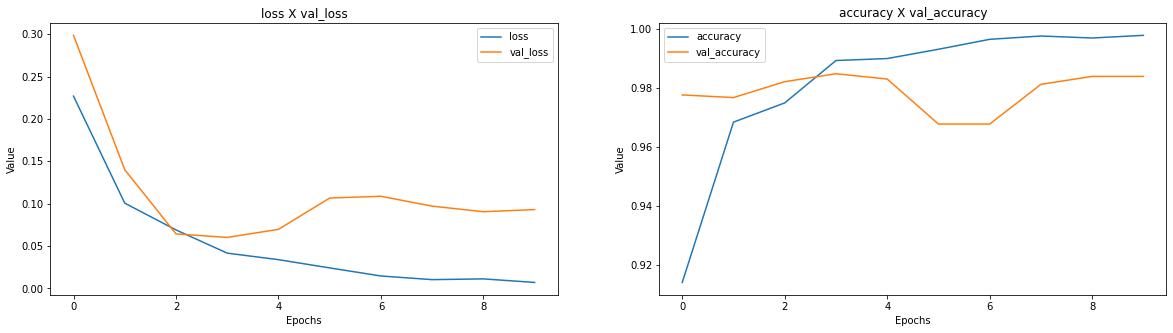

In [69]:
learning_curve(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

In [70]:
yp = model.predict(x_test)
yp

35/35 [==============================] - 2s 42ms/step


array([[9.7834736e-06],
       [7.9891345e-07],
       [1.4413538e-06],
       ...,
       [2.5906509e-13],
       [1.3898419e-05],
       [6.8033631e-07]], dtype=float32)

In [71]:
yp = (model.predict(x_test)>0.5).astype('int32')
yp

35/35 [==============================] - 2s 45ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

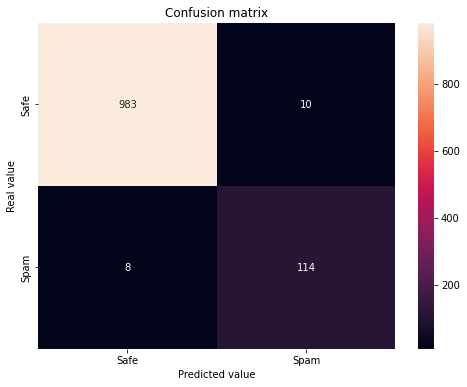

In [72]:
seaborn_conf(y_test, yp)

##<h2>Transformers - BERT</h2>

BERT has revolutionized the world of NLP by providing state-of-the-art results on many NLP tasks. BERT stands for Bidirectional Encoder Representation from Transformer. It is the state-of-the-art embedding model published by Google. It has created a major breakthrough in the field of NLP by providing greater results in many NLP tasks, such as question answering, text generation, sentence classification, and many more besides. One of the major reasons for the success of BERT is that it is a context-based embedding model, unlike other popular embedding models, such as word2vec, which are context-free.

In [73]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.4 MB/s eta 0:00:00


In [74]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [75]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length):
    input_ids=[]
    attention_masks=[]
    for text in data:
        encoded = tokenizer.encode_plus(text, add_special_tokens=True, max_length = maximum_length, pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [76]:
np.max(df['text'].apply(lambda x: len(x.split())).values)

80

In [77]:
bt_text = df['text']
bt_label = df['label_num']

bt_ids, bt_masks = bert_encode(bt_text, 80)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [78]:
from transformers import TFBertModel
def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(80,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(80,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [79]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [80]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 80,                                            

In [81]:
history = model.fit([bt_ids, bt_masks], bt_label, validation_split=0.25, epochs=1, batch_size=10)

418/418 [==============================] - 5024s 12s/step - loss: 0.4448 - accuracy: 0.8579 - val_loss: 0.4121 - val_accuracy: 0.8693


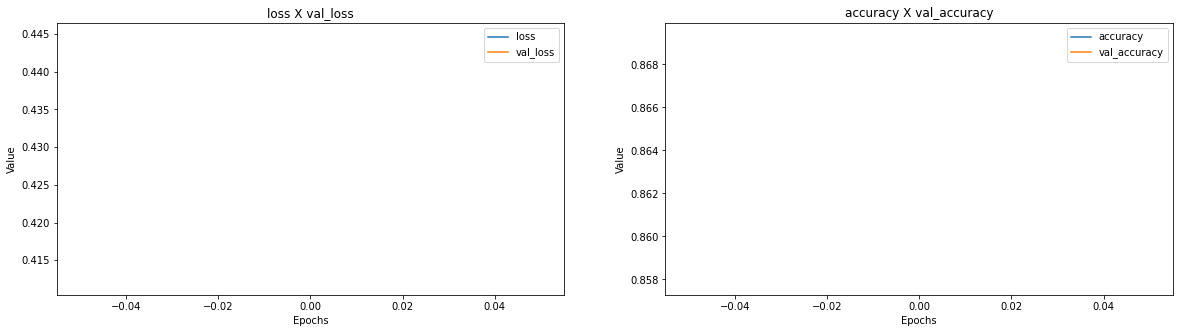

In [82]:
learning_curve(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

#<h2>Working with disaster tweets - Dataset</h2>

In [83]:
train = "https://raw.githubusercontent.com/Sahel-Eskandar/Text-Classification-Sentimental-Analysis/main/Data/train.csv"

test = "https://raw.githubusercontent.com/Sahel-Eskandar/Text-Classification-Sentimental-Analysis/main/Data/test.csv"

In [84]:
df_train = pd.read_csv(train, encoding = "ISO-8859-1", error_bad_lines=False)
df_test = pd.read_csv(test, encoding = "ISO-8859-1", error_bad_lines=False)

df_train = df_train.dropna(axis=1)
df_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [85]:
df_train.groupby('target').count()

,id,text
target,,
0,4342,4342
1,3271,3271


In [86]:
# We can use .agg('count').values also
class_counts = df_train.groupby('target').id.count().values
class_counts

array([4342, 3271])

In [87]:
fig = go.Figure()

fig.add_trace(go.Bar(
        x=['Fake disaster'],
        y=[class_counts[0]],
        name='Fake',
        text=[class_counts[0]],
        textposition='auto',
        marker_color=pblue
)
             )
fig.add_trace(go.Bar(
        x=['Real disaster'],
        y=[class_counts[1]],
        name='Real',
        text=[class_counts[1]],
        textposition='auto',
        marker_color=pg
))

fig.update_layout(
    title='Class distribution in the dataset')

fig.show()

In [88]:
len_real = df_train[df_train['target']==1].text.apply(lambda x: len(x.split())).value_counts().sort_index()
len_fake = df_train[df_train['target']==0].text.apply(lambda x: len(x.split())).value_counts().sort_index()

In [89]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=len_real.index,
    y=len_real.values,
    name='Real disaster',
    fill='tozeroy',
    marker_color=pblue,
))
fig.add_trace(go.Scatter(
    x=len_fake.index,
    y=len_fake.values,
    name='Fake disaster',
    fill='tozeroy',
    marker_color=pg,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.show()

<h2>Data pre-processing and cleaning</h2>

In [90]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [91]:
# Testing the function
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [92]:
stopw = stopwords.words('english')
more = ['u', 'im', 'c']
stopw = stopw + more

stemmer = nltk.SnowballStemmer('english')

def data_cleaning(text):
    text = clean_text(text)
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stopw)
    return text

In [93]:
df_train['cleaned_text'] = df_train['text'].apply(data_cleaning)
df_test['cleaned_text'] = df_test['text'].apply(data_cleaning)

In [94]:
df_train.head()

,id,text,target,cleaned_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


<h2>WordCloud analysis</h2>

In [95]:
def corpus(df, label):
    corpus=[]
    for x in df[df['target']==label]['cleaned_text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [96]:
corpus_reald = corpus(df_train, 1)
dic = defaultdict(int)

# Creating a dictionary with frequency of words
for word in corpus_reald:
    dic[word]+=1
    
# Sorting words by descending frequency
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
top

[('fire', 266),
 ('bomb', 179),
 ('kill', 158),
 ('news', 132),
 ('via', 121),
 ('flood', 120),
 ('disast', 116),
 ('california', 115),
 ('crash', 110),
 ('suicid', 110)]

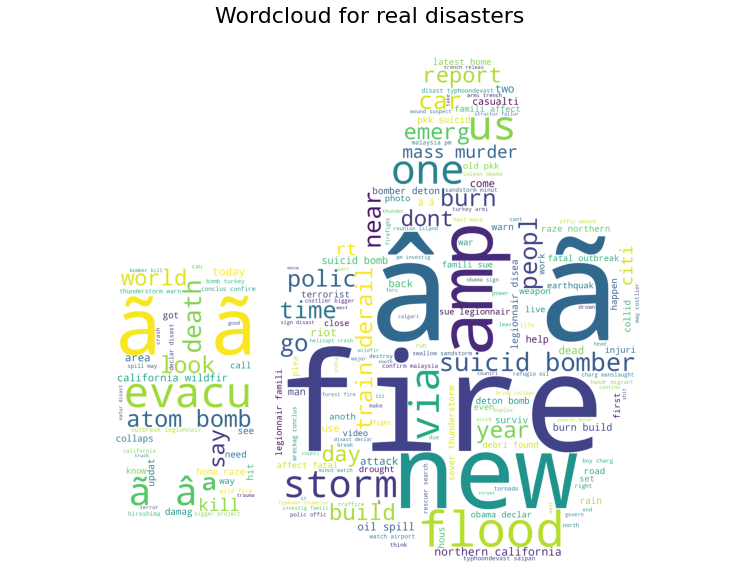

In [97]:
twitter = 'https://raw.githubusercontent.com/Sahel-Eskandar/Text-Classification-Sentimental-Analysis/main/Data/bird2.png'
response3 = requests.get(twitter)
img3 = Image.open(BytesIO(response3.content))
twitter_mask = np.array(img3)

wc = WordCloud(background_color='white', max_words=200, mask=upvote_mask)

wc.generate(' '.join(text for text in df_train.loc[df_train['target'] == 1, 'cleaned_text']))
plt.figure(figsize=(18,10))
plt.title('Wordcloud for real disasters', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [98]:
corpus_faked = corpus(df_train, 0)
dic = defaultdict(int)

# Creating a dictionary with frequency of words
for word in corpus_faked:
    dic[word]+=1
    
# Sorting words by descending frequency
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
top

[('like', 306),
 ('get', 222),
 ('amp', 192),
 ('new', 168),
 ('go', 142),
 ('dont', 139),
 ('one', 134),
 ('bodi', 116),
 ('love', 115),
 ('bag', 108)]

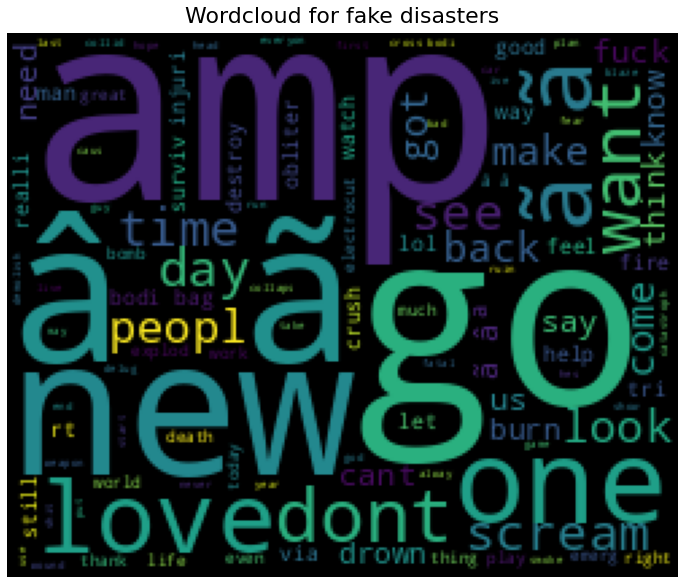

In [99]:
wc = WordCloud( 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df_train.loc[df_train['target'] == 0, 'cleaned_text']))
plt.figure(figsize=(18,10))
plt.title('Wordcloud for fake disasters', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<h2>Model creation and testing</h2>

In [100]:
x = df_train['cleaned_text']
y = df_train['target']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)
len(x_train), len(y_train), len(x_test), len(y_test)

(5709, 5709, 1904, 1904)

Training accuracy: 0.8570677877036259
Testing accuracy: 0.7820378151260504


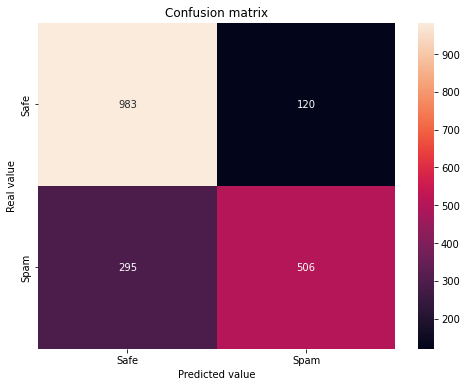

In [101]:
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
    ))
])

pipe.fit(x_train, y_train)
yp_test = pipe.predict(x_test)
yp_train = pipe.predict(x_train)

print('Training accuracy: {}'.format(metrics.accuracy_score(y_train, yp_train)))
print('Testing accuracy: {}'.format(metrics.accuracy_score(y_test, yp_test)))

seaborn_conf(y_test, yp_test)

<h3>GloVE - LSTM</h2>

In [102]:
training = df_train['cleaned_text'].values
testing = df_test['cleaned_text'].values
# Target labels
labels = df_train['target'].values

In [103]:
# Word tokenizer
tk = Tokenizer()
tk.fit_on_texts(training)

vocab = len(tk.word_index)+1
vocab

13704

In [104]:
def metric_calculation(y_test, y_pred):
    print("F1-score: ", f1_score(y_pred, y_test))
    print("Precision: ", precision_score(y_pred, y_test))
    print("Recall: ", recall_score(y_pred, y_test))
    print("Acuracy: ", accuracy_score(y_pred, y_test))
    print("-"*50)
    print(classification_report(y_pred, y_test))
    
def embeddings(corpus): 
    return tk.texts_to_sequences(corpus)

In [105]:
len_train = np.max(df_train['cleaned_text'].apply(lambda x: len(x)))
len_train

128

In [106]:
train_padded_sentences = pad_sequences(
    embeddings(training), 
    len_train, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embeddings(testing), 
    len_train,
    padding='post'
)

train_padded_sentences

array([[3635,  467,  201, ...,    0,    0,    0],
       [ 136,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1807, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2637, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]], dtype=int32)

In [107]:
# As we've already created a GloVe dictionary in the SMS-dataset, we will start with the matrix

embedding_matrix = np.zeros((vocab, embedding_dim))

for word, index in tk.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [108]:
x_train, x_test, y_train, y_test = train_test_split(train_padded_sentences, labels, test_size=0.20)

In [109]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                   output_dim=embedding_matrix.shape[1],
                   weights=[embedding_matrix],
                   input_length=max_len
                   )
         )
model.add(Bidirectional(LSTM(max_len, return_sequences=True, recurrent_dropout=0.15)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(max_len, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(max_len, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 100)           1370400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 160)          115840    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 160)              0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_1 (Batc  (None, 160)              640       
 hNormalization)                                                 
                                                                 
 dropout_41 (Dropout)        (None, 160)               0         
                                                      

In [110]:
# Callbacks
checkpoint = ModelCheckpoint('model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 5,                        min_lr = 0.001)

history = model.fit(x_train, y_train, epochs = 7,batch_size = 32,validation_data = (x_test, y_test),verbose = 1,callbacks = [reduce_lr, checkpoint])

Epoch 1/7


ValueError: ignored

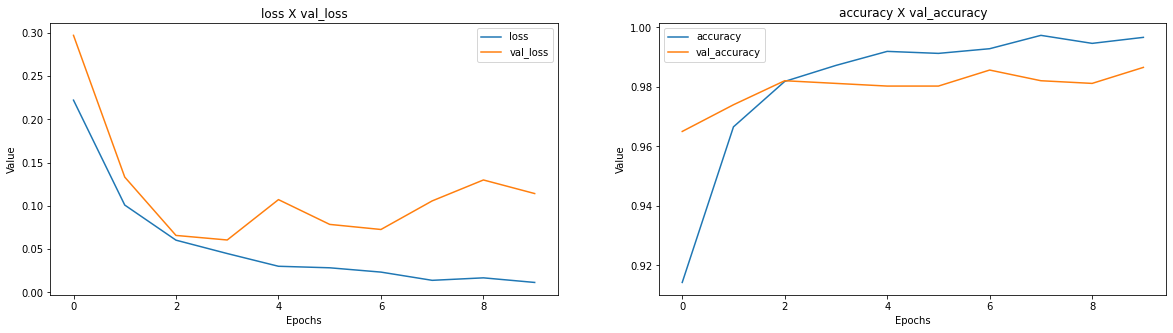

In [152]:
learning_curve(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [154]:
preds = model.predict(x_test,)
metric_calculation(preds, y_test)

ValueError: ignored